## 练习4-5
学习Voss-McCartney算法，使用它产生粉红噪声，计算结果的功率谱。


之前使用的生成粉红噪声的方法一般是，对一个均匀谱的分量乘以1/f，以得到递减的功率谱，即粉红噪声的功率谱，再对这个功率谱做ifft，得到时域的噪声信号。但这种方法计算较慢效率较低。
Voss-McCartney 算法是一种高效生成高质量粉红噪声（1/f 噪声）的方法，其核心思想是通过叠加多个不同频率的随机变量来实现功率谱密度随频率以 1/f 衰减的特性。该算法相比传统的 FFT 方法计算效率更高，尤其适合实时生成粉红噪声。

粉红噪声的功率谱密度与频率成反比（1/f），而 Voss-McCartney 算法通过以下步骤实现这一特性：
- 初始化：创建一组随机数寄存器（通常为 5-8 个），每个寄存器以不同的速率更新（例如，第 k 个寄存器每\(2^k\)个样本更新一次）。
- 更新寄存器：在每个时间步，只有部分寄存器会被随机数替换，其余保持不变。
- 叠加输出：将所有寄存器的值相加，得到当前时间步的粉红噪声样本。这种方法确保低频分量变化缓慢，高频分量变化频繁，从而实现 1/f 的功率谱特性。

各个寄存器的更新间隔（2的幂次方），它们组成了各个频率分量，而其中更新间隔长的分量，保持不变的次数越多，对应在低频的能量就越高
当所有寄存器的值相加时，低频分量因长时间保持不变而叠加出更强的能量，高频分量因快速变化而能量被稀释，最终实现 1/f 的功率谱特性。

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import librosa
from IPython.display import Audio
import pandas as pd

# 设置中文字体
plt.rcParams["font.family"] = ["DejaVu Sans", "SimHei", "Times New Roman"]  # 使用系统中存在的字体

In [62]:
def voss_mccartney(n_samples, n_registers=8, amplitude=1.0):
    """
    使用Voss-McCartney算法生成粉红噪声

    参数:
    n_samples: 生成的样本数
    n_registers: 使用的随机数寄存器数量（通常5-8个）
    amplitude: 输出噪声的幅度

    返回:
    粉红噪声数组
    """
    # 初始化寄存器，每个寄存器负责不同的更新频率
    registers = np.random.random(n_registers) * 2 - 1  # 每个寄存器的初始值为范围[-1, 1]内的随机数
    result = np.zeros(n_samples)  # 初始化存储噪声样本的序列

    # 各个寄存器的更新间隔（2的幂次方），它们组成了各个频率分量，而其中更新间隔长的分量，保持不变的次数越多，对应在低频的能量就越高
    # 当所有寄存器的值相加时，低频分量因长时间保持不变而叠加出更强的能量，高频分量因快速变化而能量被稀释，最终实现 1/f 的功率谱特性。
    update_points = [2**i for i in range(n_registers)]

    for i in range(n_samples):
        # 确定当前需要更新的寄存器
        for j in range(n_registers):  # 判断寄存器是否需要更新（重新取随机数）
            if i % update_points[j] == 0:
                registers[j] = np.random.random() * 2 - 1

        # 当前样本值为所有寄存器的和
        result[i] = np.sum(registers)

    # 归一化并调整幅度
    return result / np.std(result) * amplitude

In [63]:
# 生成粉红噪声
fs = 44100  # 采样率 (Hz)
duration = 1  # 信号时长 (s)
n_samples = int(fs * duration)
pink_noise = voss_mccartney(n_samples, n_registers=6, amplitude=100)
print(pink_noise)

[145.30539824  75.51649337 102.34474743 ... 139.86307328  67.86026892
 160.76767811]


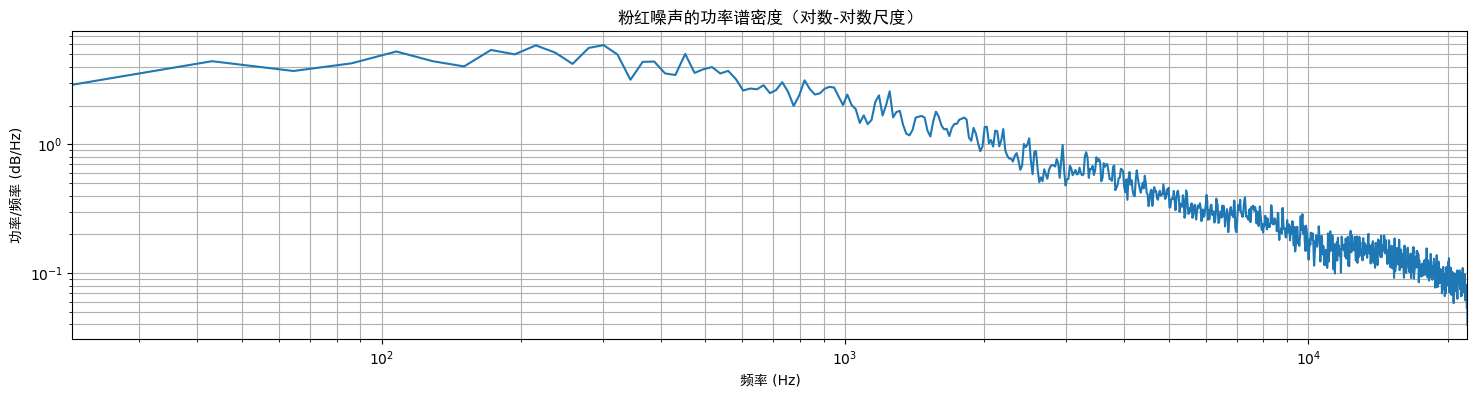

In [64]:
# 可视化功率谱密度（验证1/f特性）
f, pxx = signal.welch(pink_noise, fs, nperseg=2048)
plt.figure(figsize=(18, 4))
plt.loglog(f[1:], pxx[1:])  # 跳过DC分量
plt.xlim(f[1], f.max())
plt.title('粉红噪声的功率谱密度（对数-对数尺度）')
plt.xlabel('频率 (Hz)')
plt.ylabel('功率/频率 (dB/Hz)')
plt.grid(True, which='both')